In [1]:
from _Setup import *
from _Functions import *

Installing dependencies from requirements.txt...
All dependencies installed successfully.


In [2]:
# Load data as csv
sector_train = pd.read_csv(sector_data_csv_path_train_pivoted, index_col='Area of Responsibility')

# Import the scaler
with open(scalers_file, "rb") as file:
    scalers = pickle.load(file)

# DONE : Create scaled version of original Dataframe
# Apply pre-trained scalers row-wise

# Create an empty DataFrame to store scaled values
sector_train_scaled = pd.DataFrame(index=sector_train.index, columns=sector_train.columns)

# Apply each pre-trained scaler row-wise
for index, row in sector_train.iterrows():
	scaler = scalers[index]
	scaled_row = scaler.transform(row.values.reshape(-1, 1)).flatten()
	sector_train_scaled.loc[index] = scaled_row

sector_train_scaled.head()

,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,...,2023-09-01,2023-10-01,2023-11-01,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01
Area of Responsibility,,,,,,,,,,,,,,,,,,,,,
Atlanta Field Office,0.309259,0.148765,0.026543,0.003704,0.0,0.201235,0.318519,1.0,0.624074,0.559877,...,0.388272,0.244444,0.401852,0.287654,0.340741,0.267284,0.329012,0.324691,0.340741,0.301235
Baltimore Field Office,0.202374,0.26286,0.323912,0.346523,0.325042,0.159412,0.0,0.052007,0.036744,0.017524,...,0.940079,0.851328,0.811758,0.821933,0.836631,0.848502,0.765969,0.681176,0.66026,0.74788
Big Bend Sector,0.090589,0.064323,0.067839,0.080455,0.071768,0.09514,0.060393,0.085419,0.092037,0.109824,...,0.071355,0.054602,0.04364,0.02213,0.022544,0.073009,0.045708,0.064943,0.110858,0.0
Blaine Sector,0.091463,0.067073,0.103659,0.070122,0.07622,0.042683,0.012195,0.033537,0.009146,0.039634,...,0.658537,0.692073,0.597561,0.881098,0.67378,0.710366,0.682927,1.0,0.804878,0.545732
Boston Field Office,0.242847,0.171496,0.272365,0.16226,0.234698,0.100869,0.0431,0.0,0.040746,0.027888,...,1.0,0.61427,0.578776,0.757334,0.806592,0.644151,0.847881,0.88573,0.861101,0.807678


In [3]:
# Import Test data
test_data = pd.read_csv(sector_data_csv_path_test_pivoted, index_col='Area of Responsibility')
test_data.shape

(41, 6)

In [9]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import itertools
import warnings

warnings.filterwarnings("ignore")  # Suppress warnings

# Define the range of ARIMA parameters to search
p_values = range(0, 4)  # Autoregressive terms
d_values = range(0, 2)  # Differencing order
q_values = range(0, 4)  # Moving average terms

# Generate all (p, d, q) combinations safely
pdq_combinations = list(itertools.product(p_values, d_values, q_values))

# Ensure all values are valid integers (avoid NaNs, None, etc.)
fixed_pdq_combinations = [
    tuple(int(value) for value in order)  # Explicit integer conversion
    for order in pdq_combinations
]

# Dictionary to store predictions
predictions_dict = {}

# Iterate over each time series row
for index, row in sector_train_scaled.iterrows():
    try:
        # Convert row to numeric and drop NaN values
        input_series = pd.to_numeric(row, errors='coerce').dropna().values.flatten()

        # Ensure input_series is numeric and of sufficient length
        if len(input_series) < 3:
            print(f"Skipping index {index}: Not enough data points for ARIMA.")
            continue
        
        # Grid search to find the best ARIMA parameters
        best_aic = float("inf")
        best_order = None
        best_model = None

        for order in fixed_pdq_combinations:
            try:
                model = ARIMA(input_series, order=order)
                fitted_model = model.fit()
                aic = fitted_model.aic  # Akaike Information Criterion

                if aic < best_aic:
                    best_aic = aic
                    best_order = order
                    best_model = fitted_model

            except Exception as e:
                print(f"Skipping ARIMA{order} for index {index}: {e}")
                continue  # Skip parameter sets that fail to converge

        # Ensure a valid model was selected
        if best_model is not None and index in test_data.index:
            test_set = test_data.loc[index]
            steps_ahead = len(test_set)

            if steps_ahead > 0:
                try:
                    # Forecast future values
                    predictions = best_model.forecast(steps=steps_ahead).flatten()

                    # Inverse transform predictions if applicable
                    if index in scalers:
                        predictions = scalers[index].inverse_transform(
                            predictions.reshape(-1, 1)
                        ).flatten()

                    # Store predictions
                    predictions_dict[index] = predictions

                except Exception as e:
                    print(f"Error in forecasting for {index}: {e}")

    except Exception as e:
        print(f"Skipping index {index} due to unexpected error: {e}")

In [25]:
predictions_dict['Tucson Sector']

array([22436., 22436., 22436., 22436., 22436., 22436.])

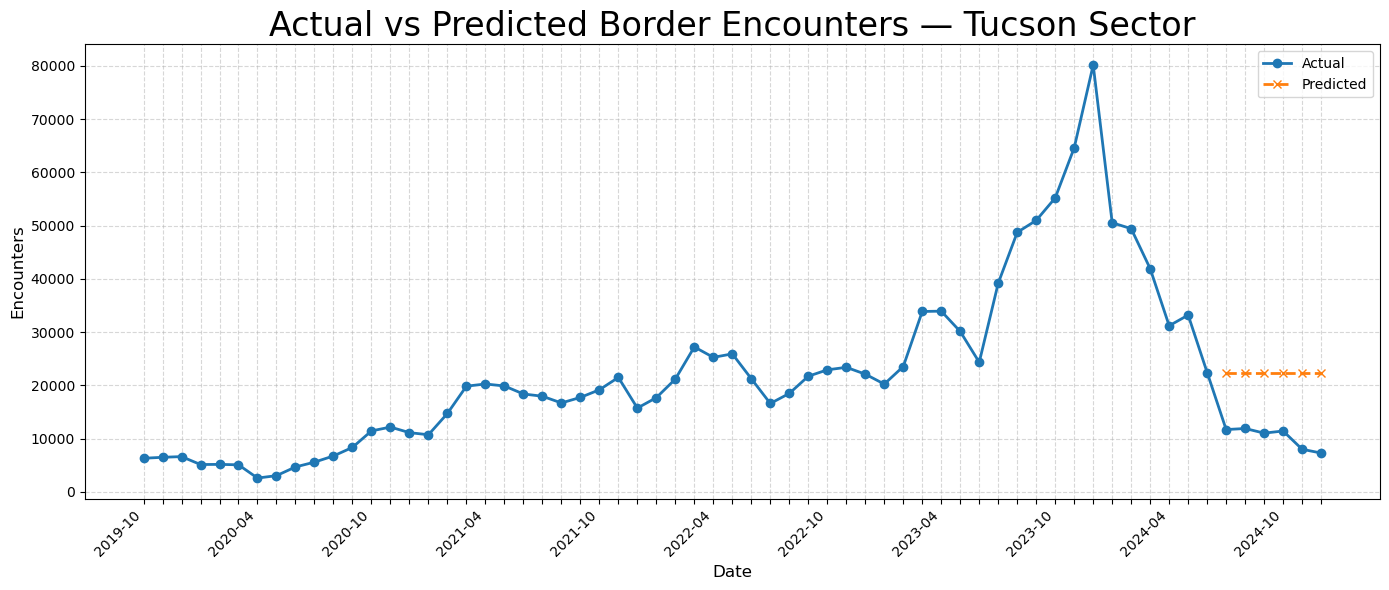

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define sector to visualize
sector_name = "Tucson Sector"

# Extract relevant values
actual_values = test_data.loc[sector_name].values if sector_name in test_data.index else []
predicted_values = predictions_dict.get(sector_name, [])
sector_train_values = sector_train.loc[sector_name].values if sector_name in sector_train.index else []

# Check for data availability
if len(actual_values) == 0 or len(predicted_values) == 0 or len(sector_train_values) == 0:
    print(f"[ERROR] Missing data for '{sector_name}'. Check training, testing, and prediction sources.")
else:
    # Combine training and testing actuals for full timeline
    extended_actual_values = np.concatenate([sector_train_values, actual_values])
    extended_predicted_values = np.concatenate([np.full(len(sector_train_values), np.nan), predicted_values])

    # Build timeline labels (monthly)
    start_date = pd.to_datetime(sector_train.columns[0])
    total_months = len(extended_actual_values)
    date_range = pd.date_range(start=start_date, periods=total_months, freq='MS')
    x_labels = [date.strftime('%Y-%m') if i % 6 == 0 else '' for i, date in enumerate(date_range)]

    # Plot actual vs. predicted
    plt.figure(figsize=(14, 6))
    plt.plot(extended_actual_values, label="Actual", marker='o', linewidth=2)
    plt.plot(extended_predicted_values, label="Predicted", marker='x', linestyle='--', linewidth=2)

    # Plot formatting
    plt.title(f"Actual vs Predicted Border Encounters — {sector_name}", fontsize=24)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Encounters", fontsize=12)
    plt.xticks(ticks=np.arange(total_months), labels=x_labels, rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()
